<a   href="https://colab.research.google.com/github/N-Nieto/OHBM_SEA-SIG_Educational_Course/blob/master/03_pitfalls/03_03_imbalance_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalance learning: Metrics

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
)

from imblearn.metrics import sensitivity_specificity_support

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore


### Data loading and preparation

In [2]:
# Prepare the data
# Features: Cortical + Subcortical
features = ["cortical", "subcortical"]

# Target: Height
target = ["SEX_ID (1=m, 2=f)"]
# Confounding variables: Sex, Age
confounding = ["SEX_ID (1=m, 2=f)", "AGE"]
confounding = []


df_data = pd.read_csv("cleaned_IXI_behavioural.csv", index_col=0)
columns_features = []
for feature in features:
    if feature == "cortical":
        df_feature = pd.read_csv(
            "cleaned_VBM_GM_Schaefer100x17_mean_aggregation.csv", index_col=0
        )
    elif feature == "subcortical":
        df_feature = pd.read_csv(
            "cleaned_VBM_GM_TianxS1x3TxMNI6thgeneration_mean_aggregation.csv",
            index_col=0,
        )
    else:
        print("feature not recognized")

    df_data = df_data.join(df_feature, how="inner")
    columns_features = columns_features + df_feature.columns.to_list()


print(f"Initial data shape: {df_data.shape}")

# Check for NaNs in confounding columns
confounding_cols = target + confounding
for col in confounding_cols:
    if df_data[col].isna().sum() > 0:
        print(f"{df_data[col].isna().sum()} NaNs in column {col}.")
        print("Drop NaNs and align subjects")

        # Drop NaNs from the brain dataframe (which contains all columns)
        df_data = df_data.dropna(subset=[col])
        print(f"New data shape: {df_data.shape}")
    else:
        print(f"No NaNs in column {col}.")

print(f"Final data shape: {df_data.shape}")

y = df_data[target].values.ravel()
if target == ["SEX_ID (1=m, 2=f)"]:
    y = np.where(y == 2, 0, 1)  # 1


X = df_data.loc[:, columns_features].values  # only brain features

print("X shape")
print(X.shape)


Initial data shape: (591, 122)
No NaNs in column SEX_ID (1=m, 2=f).
Final data shape: (591, 122)
X shape
(591, 116)


### Forcing Imbalance

In [3]:
# Force imbalance in the dataset
imbalance_ratio = 0.15  # Minority class will be 10% of majority class
X_minority = X[y == 0]
y_minority = y[y == 0]
X_majority = X[y == 1][: int(imbalance_ratio * len(X_minority))]
y_majority = y[y == 1][
    : int(imbalance_ratio * len(X_minority))
]  # Keep only 10% of majority class
X = np.vstack((X_minority, X_majority))
y = np.hstack((y_minority, y_majority))

print("X shape")
print(X.shape)
print("Target distribution")
print(y.sum(), len(y) - y.sum())
print(f"Imbalance ratio: {y.sum()/len(y):.2f}")

X shape
(377, 116)
Target distribution
49 328
Imbalance ratio: 0.13


## Training a ML model and plot performance

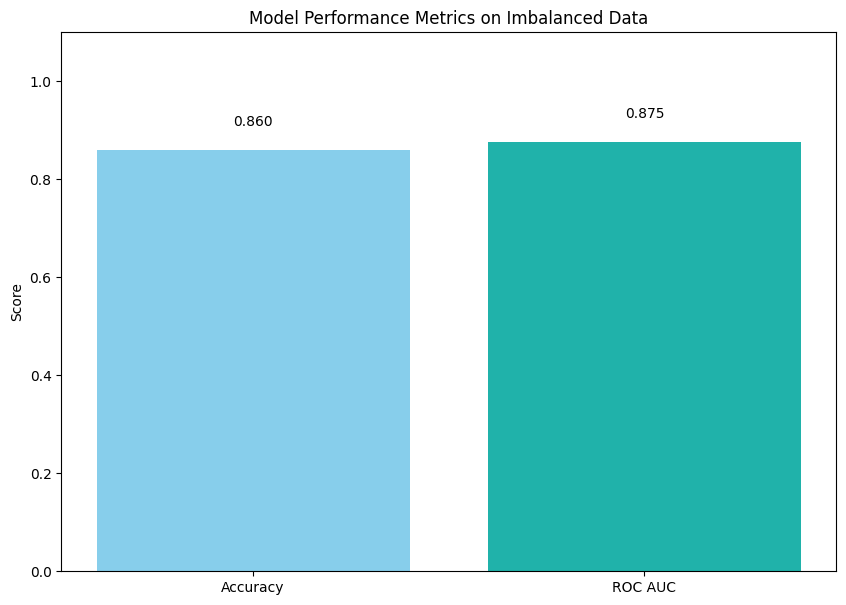

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_proba),
}


# Plot metrics
plt.figure(figsize=(10, 7))
plt.bar(
    metrics.keys(),
    metrics.values(),
    color=[
        "skyblue",
        "lightseagreen",
    ],
)
plt.title("Model Performance Metrics on Imbalanced Data")
plt.ylim(0, 1.1)
plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.05, f"{v:.3f}", ha="center")
plt.show()


## Looks great, doesn't it?!

### Let's now take a look at our confusion matrix

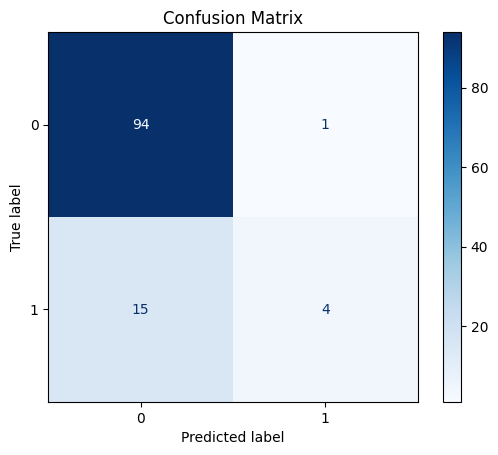

In [5]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Wait, we clearly have a problem, our classifier is not working well in our minority class!

## We need to characterize better our results. Let's calculate more metrics!

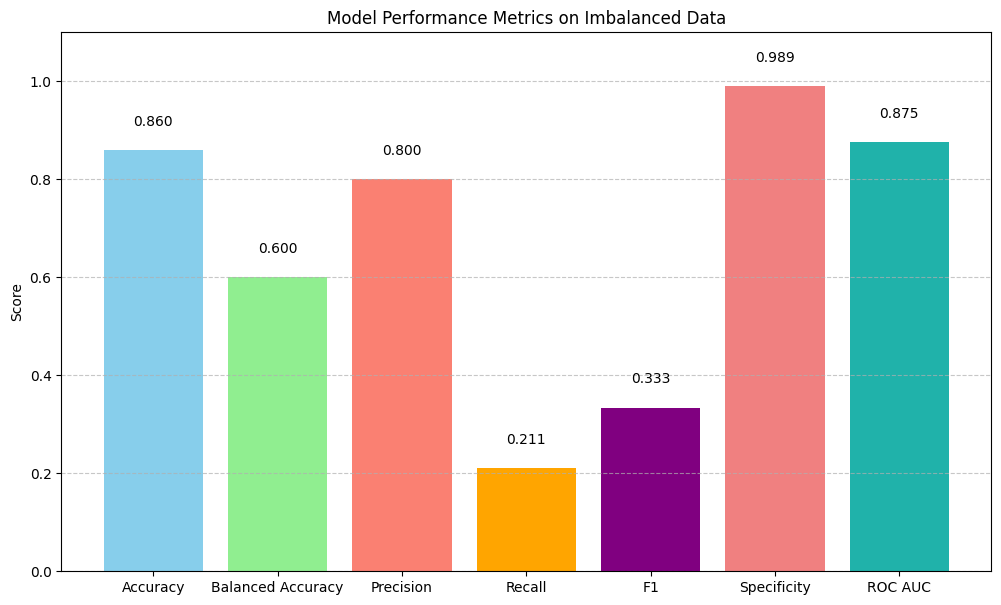

In [16]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "Specificity": sensitivity_specificity_support(y_test, y_pred)[0][0],
    "ROC AUC": roc_auc_score(y_test, y_proba),
}


# Plot metrics
plt.figure(figsize=(12, 7))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.bar(
    metrics.keys(),
    metrics.values(),
    color=[
        "skyblue",
        "lightgreen",
        "salmon",
        "orange",
        "purple",
        "lightcoral",
        "lightseagreen",
    ],
)
plt.title("Model Performance Metrics on Imbalanced Data")
plt.ylim(0, 1.1)

plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.05, f"{v:.3f}", ha="center")
plt.show()


# Question

What is your take from the metrics?

We should always report several metrics, to better understand the models' performance.

# ----------------------------------------------------------------

# Threshold ajustment

## By default, sklearn prediction use a threshold of 0.5, but we could aproximate a better threshold

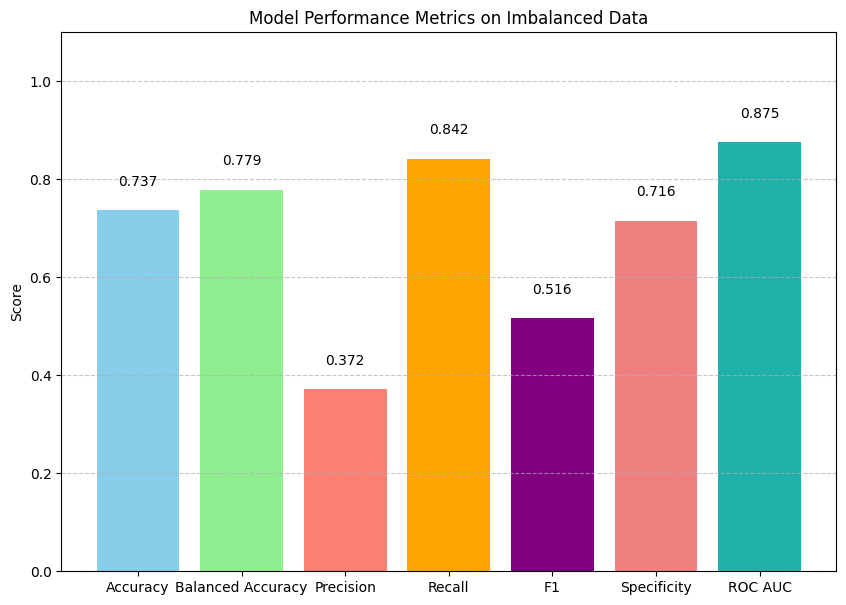

In [17]:
# get the probabilities again
y_proba = model.predict_proba(X_test)[:, 1]

# Adjust threshold based on class imbalance
# this is an approximation of the optimal threshold in terms of balanced accuracy
thd = y.sum()/len(y)

# Get new predictions using the adjusted threshold
y_pred = y_proba >= thd
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "Specificity": sensitivity_specificity_support(y_test, y_pred)[0][0],
    "ROC AUC": roc_auc_score(y_test, y_proba),
}


# Plot metrics
plt.figure(figsize=(10, 7))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.bar(
    metrics.keys(),
    metrics.values(),
    color=[
        "skyblue",
        "lightgreen",
        "salmon",
        "orange",
        "purple",
        "lightcoral",
        "lightseagreen",
    ],
)
plt.title("Model Performance Metrics on Imbalanced Data")
plt.ylim(0, 1.1)

plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.05, f"{v:.3f}", ha="center")
plt.show()

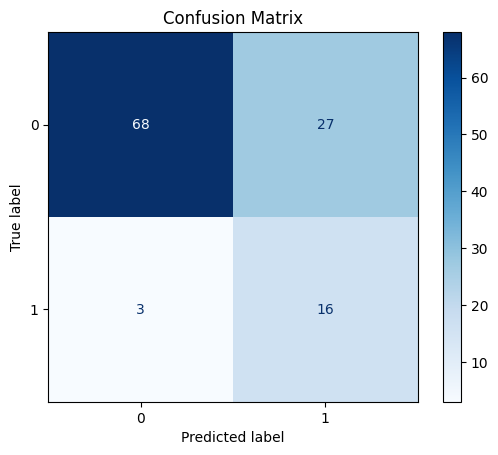

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Questions

What can you observe? How is the relationship between ACC and Balanced ACC now?

Did AUC change? Why, why not?

We improved our performance on the minority class, but at what cost?

The decision of which type of error is more critical is problem dependant, you as the expert, will have to take this decision.

So far, we did not change the model itself, only treated differently the predictions that the model made.
In the next notebook, we will explore particular techniques to deal with imbalance problems.

# Oversampling

In [9]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Random oversampling of minority class
ros = RandomOverSampler(random_state=23)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Train on resampled data
model_ros = LogisticRegression(max_iter=1000)
model_ros.fit(X_resampled, y_resampled)
y_pred_ros = model_ros.predict(X_test)

# Calculate metrics after resampling
metrics_ros = {
    "Accuracy": accuracy_score(y_test, y_pred_ros),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_ros),
    "Precision": precision_score(y_test, y_pred_ros),
    "Recall": recall_score(y_test, y_pred_ros),
    "F1": f1_score(y_test, y_pred_ros),

    "Specificity": sensitivity_specificity_support(y_test, y_pred_ros)[0][0],
    "ROC AUC": roc_auc_score(y_test, model_ros.predict_proba(X_test)[:, 1]),
}

# Random oversampling of minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Train on resampled data
model_smote = LogisticRegression(max_iter=1000)
model_smote.fit(X_resampled, y_resampled)
y_pred_smote = model_smote.predict(X_test)

# Calculate metrics after resampling
metrics_smote = {
    "Accuracy": accuracy_score(y_test, y_pred_smote),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_smote),
    "Precision": precision_score(y_test, y_pred_smote),
    "Recall": recall_score(y_test, y_pred_smote),
    "F1": f1_score(y_test, y_pred_smote),

    "Specificity": sensitivity_specificity_support(y_test, y_pred_smote)[0][0],
    "ROC AUC": roc_auc_score(y_test, model_smote.predict_proba(X_test)[:, 1]),
}


## Lets plot and compare several metrics 

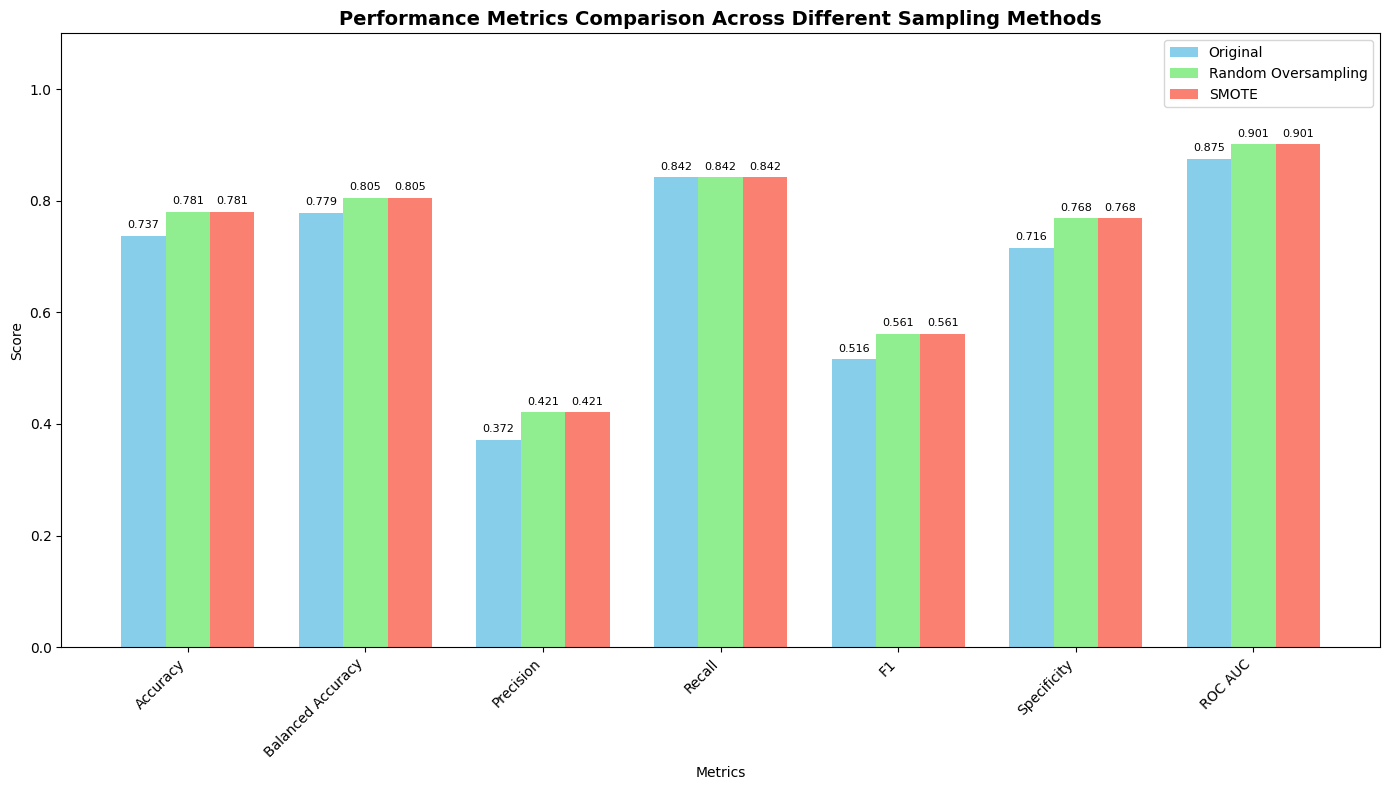

In [10]:

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Original': metrics,
    'Random Oversampling': metrics_ros,
    'SMOTE': metrics_smote
})

# Plot comparison - one metric per subplot
metrics_list = list(metrics.keys())
n_metrics = len(metrics_list)

# Alternative: Single plot with all metrics grouped by method
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(metrics_list))
width = 0.25

bars1 = ax.bar(x - width, [metrics[m] for m in metrics_list], width, 
               label='Original', color='skyblue')
bars2 = ax.bar(x, [metrics_ros[m] for m in metrics_list], width, 
               label='Random Oversampling', color='lightgreen')
bars3 = ax.bar(x + width, [metrics_smote[m] for m in metrics_list], width, 
               label='SMOTE', color='salmon')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics Comparison Across Different Sampling Methods', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_list, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()

## Confusion matrix for oversampling

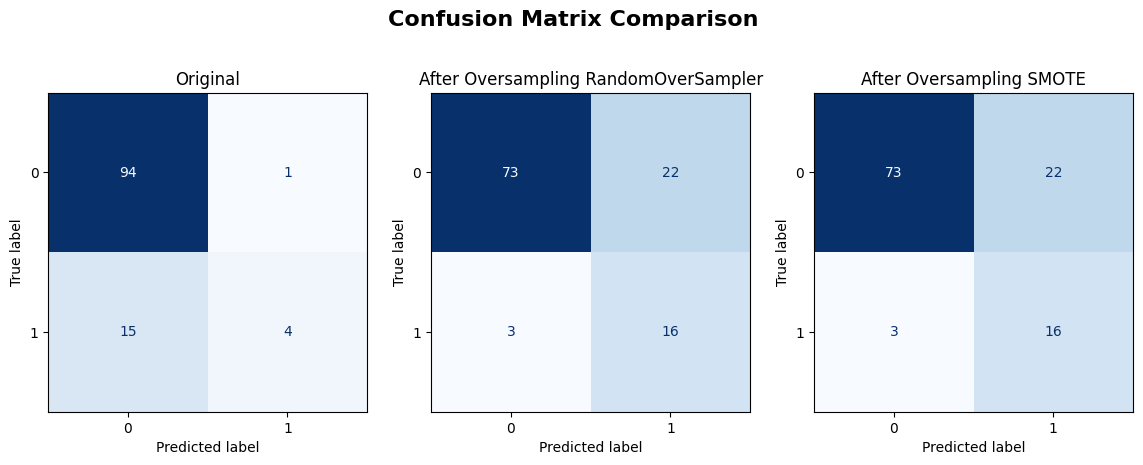

In [11]:
# Confusion matrix comparison
fig, ax = plt.subplots(1, 3, figsize=(14,5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax[0], cmap="Blues")
ax[0].set_title("Original")
ConfusionMatrixDisplay.from_estimator(model_ros, X_test, y_test, ax=ax[1], cmap="Blues")
ax[1].set_title("After Oversampling RandomOverSampler")
ConfusionMatrixDisplay.from_estimator(
    model_smote, X_test, y_test, ax=ax[2], cmap="Blues"
)
ax[2].set_title("After Oversampling SMOTE")
ax[0].figure.suptitle("Confusion Matrix Comparison", fontsize=16, fontweight='bold')
# Remove the color bar from all confusion matrix plots
for axes in ax:
    if hasattr(axes, 'images') and axes.images:
        for im in axes.images:
            if im.colorbar:
                im.colorbar.remove()

plt.show()



Metrics After Random Undersampling:
   Accuracy  Balanced Accuracy  Precision    Recall        F1   ROC AUC
0  0.736842           0.778947   0.372093  0.842105  0.516129  0.860942


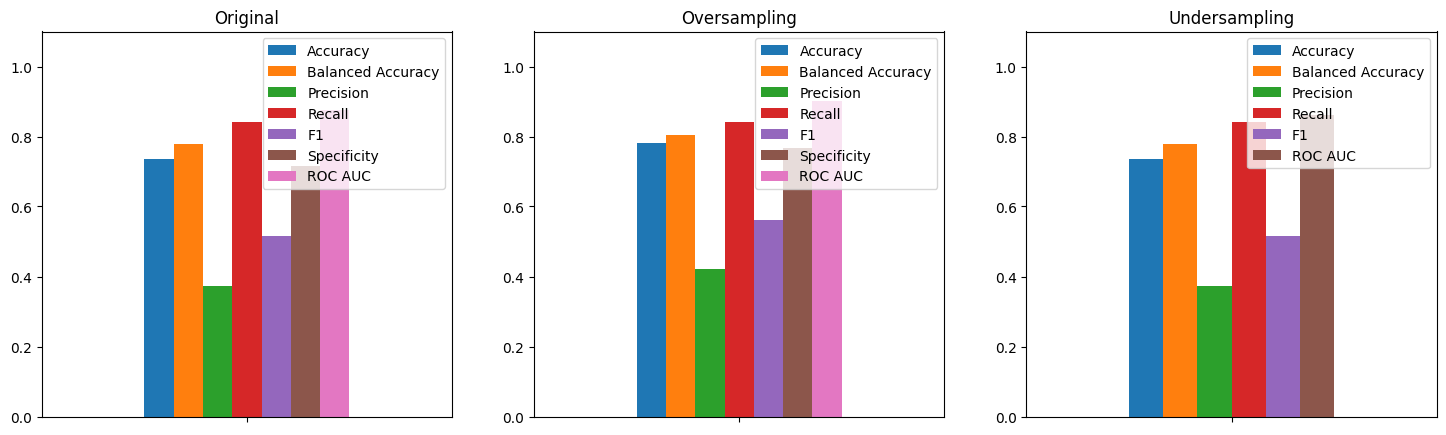

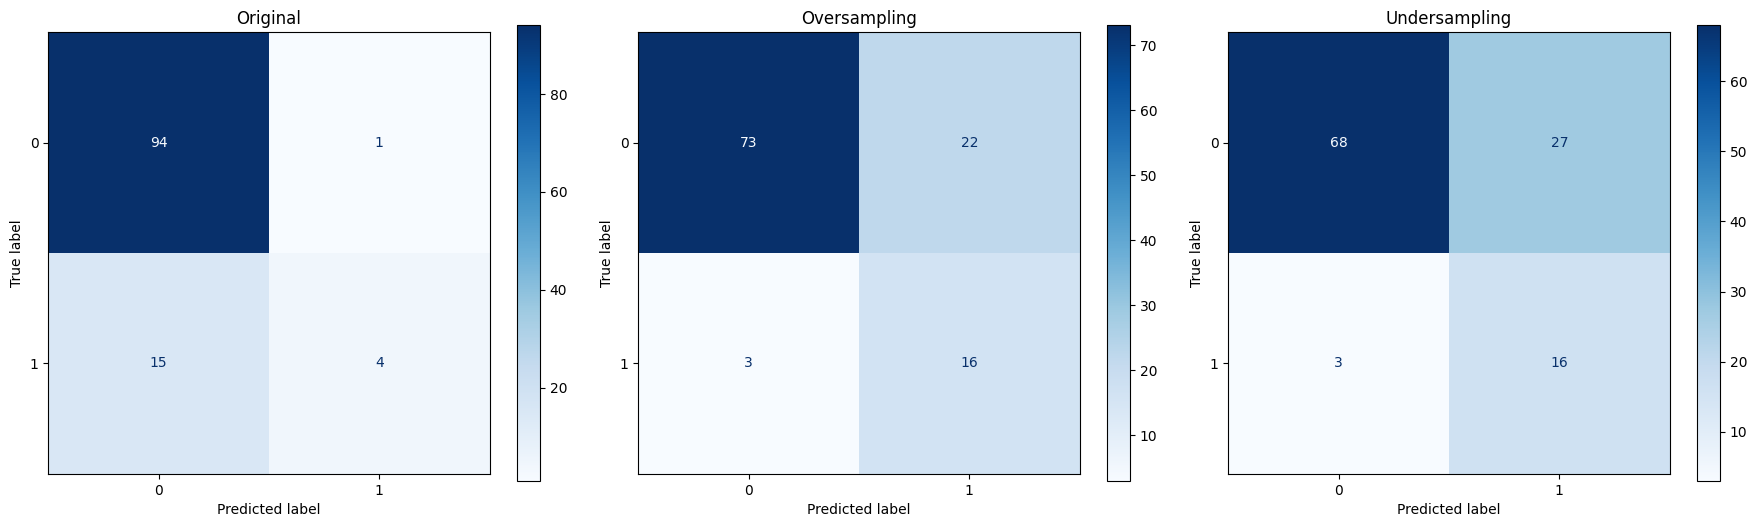

In [12]:
from imblearn.under_sampling import RandomUnderSampler

# Random undersampling of majority class
rus = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)

# Train on undersampled data
model_rus = LogisticRegression(max_iter=1000)
model_rus.fit(X_undersampled, y_undersampled)
y_pred_rus = model_rus.predict(X_test)

# Calculate metrics after undersampling
metrics_rus = {
    "Accuracy": accuracy_score(y_test, y_pred_rus),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_rus),
    "Precision": precision_score(y_test, y_pred_rus),
    "Recall": recall_score(y_test, y_pred_rus),
    "F1": f1_score(y_test, y_pred_rus),
    "ROC AUC": roc_auc_score(y_test, model_rus.predict_proba(X_test)[:, 1]),
}

print("\nMetrics After Random Undersampling:")
print(pd.DataFrame([metrics_rus]))

# Plot comparison with previous models
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
pd.DataFrame([metrics]).plot(kind="bar", ax=ax[0], title="Original")
pd.DataFrame([metrics_ros]).plot(kind="bar", ax=ax[1], title="Oversampling")
pd.DataFrame([metrics_rus]).plot(kind="bar", ax=ax[2], title="Undersampling")
for a in ax:
    a.set_ylim(0, 1.1)
    a.set_xticklabels([])
plt.show()

# Confusion matrix comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax[0], cmap="Blues")
ax[0].set_title("Original")
ConfusionMatrixDisplay.from_estimator(model_ros, X_test, y_test, ax=ax[1], cmap="Blues")
ax[1].set_title("Oversampling")
ConfusionMatrixDisplay.from_estimator(model_rus, X_test, y_test, ax=ax[2], cmap="Blues")
ax[2].set_title("Undersampling")
plt.tight_layout()
plt.show()


Metrics After Random Undersampling:
   Accuracy  Balanced Accuracy  Precision    Recall        F1   ROC AUC
0  0.780702           0.805263   0.421053  0.842105  0.561404  0.858726


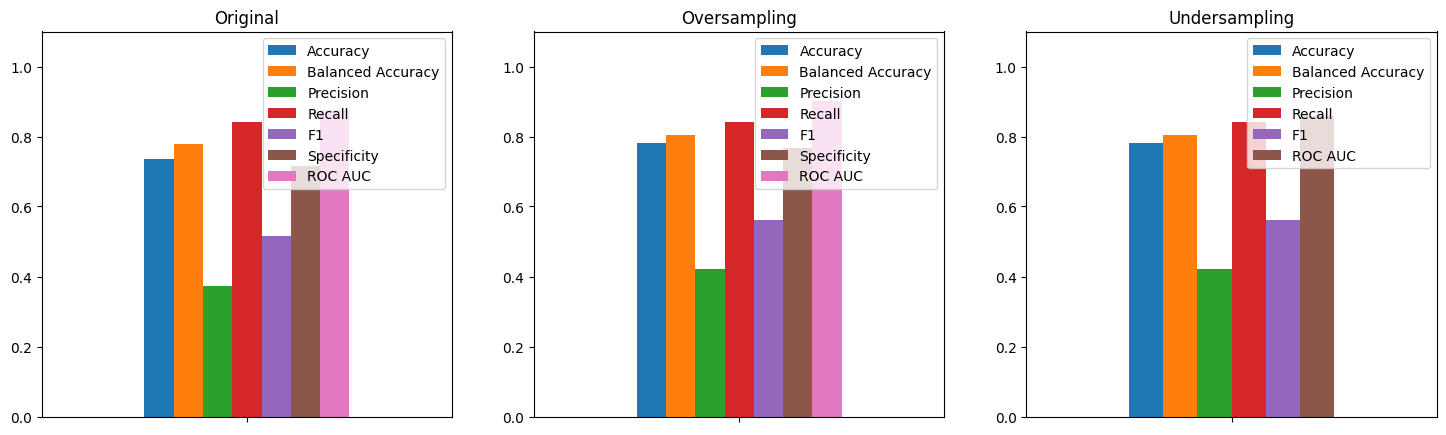

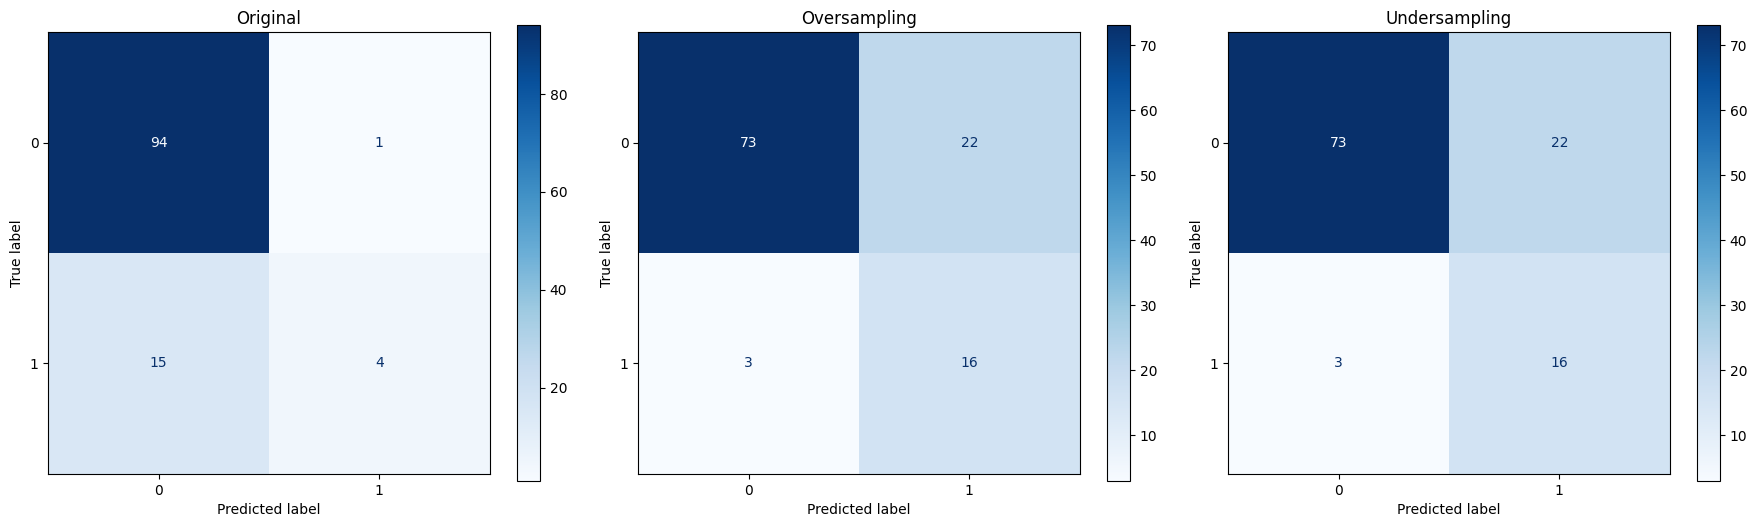

In [13]:
from imblearn.under_sampling import NearMiss

# Random undersampling of majority class
rus = NearMiss()
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)

# Train on undersampled data
model_rus = LogisticRegression(max_iter=1000)
model_rus.fit(X_undersampled, y_undersampled)
y_pred_rus = model_rus.predict(X_test)

# Calculate metrics after undersampling
metrics_rus = {
    "Accuracy": accuracy_score(y_test, y_pred_rus),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_rus),
    "Precision": precision_score(y_test, y_pred_rus),
    "Recall": recall_score(y_test, y_pred_rus),
    "F1": f1_score(y_test, y_pred_rus),
    "ROC AUC": roc_auc_score(y_test, model_rus.predict_proba(X_test)[:, 1]),
}

print("\nMetrics After Random Undersampling:")
print(pd.DataFrame([metrics_rus]))

# Plot comparison with previous models
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
pd.DataFrame([metrics]).plot(kind="bar", ax=ax[0], title="Original")
pd.DataFrame([metrics_ros]).plot(kind="bar", ax=ax[1], title="Oversampling")
pd.DataFrame([metrics_rus]).plot(kind="bar", ax=ax[2], title="Undersampling")
for a in ax:
    a.set_ylim(0, 1.1)
    a.set_xticklabels([])
plt.show()

# Confusion matrix comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax[0], cmap="Blues")
ax[0].set_title("Original")
ConfusionMatrixDisplay.from_estimator(model_ros, X_test, y_test, ax=ax[1], cmap="Blues")
ax[1].set_title("Oversampling")
ConfusionMatrixDisplay.from_estimator(model_rus, X_test, y_test, ax=ax[2], cmap="Blues")
ax[2].set_title("Undersampling")
plt.tight_layout()
plt.show()

In [14]:
X_balanced_smart.shape

NameError: name 'X_balanced_smart' is not defined

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# First, undersample the majority class using NearMiss
nm = NearMiss()
X_under_nm, y_under_nm = nm.fit_resample(X_train, y_train)

# Then, oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_balanced_smart, y_balanced_smart = smote.fit_resample(X_under_nm, y_under_nm)

# Train logistic regression on the balanced data
model_smart = LogisticRegression(max_iter=1000)
model_smart.fit(X_balanced_smart, y_balanced_smart)
y_pred_smart = model_smart.predict(X_test)

# Calculate metrics
metrics_smart = {
    "Accuracy": accuracy_score(y_test, y_pred_smart),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_smart),
    "Precision": precision_score(y_test, y_pred_smart),
    "Recall": recall_score(y_test, y_pred_smart),
    "F1": f1_score(y_test, y_pred_smart),
    "ROC AUC": roc_auc_score(y_test, model_smart.predict_proba(X_test)[:, 1]),
}

print("\nMetrics After NearMiss + SMOTE:")
print(pd.DataFrame([metrics_smart]))

# Plot comparison with previous models
fig, ax = plt.subplots(1, 4, figsize=(28, 5))
pd.DataFrame([metrics]).plot(kind="bar", ax=ax[0], title="Original")
pd.DataFrame([metrics_ros]).plot(kind="bar", ax=ax[1], title="Oversampling")
pd.DataFrame([metrics_rus]).plot(kind="bar", ax=ax[2], title="Undersampling")
pd.DataFrame([metrics_smart]).plot(kind="bar", ax=ax[3], title="NearMiss+SMOTE")
for a in ax:
    a.set_ylim(0, 1.1)
    a.set_xticklabels([])
plt.show()

# Confusion matrix comparison
fig, ax = plt.subplots(1, 4, figsize=(28, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax[0], cmap="Blues")
ax[0].set_title("Original")
ConfusionMatrixDisplay.from_estimator(model_ros, X_test, y_test, ax=ax[1], cmap="Blues")
ax[1].set_title("Oversampling")
ConfusionMatrixDisplay.from_estimator(model_rus, X_test, y_test, ax=ax[2], cmap="Blues")
ax[2].set_title("Undersampling")
ConfusionMatrixDisplay.from_estimator(
    model_smart, X_test, y_test, ax=ax[3], cmap="Blues"
)
ax[3].set_title("NearMiss+SMOTE")
plt.tight_layout()
plt.show()

# Methods

In [ ]:
# Using class weighting
model_weighted = LogisticRegression(max_iter=1000, class_weight="balanced")
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_test)

# Calculate metrics with class weighting
metrics_weighted = {
    "Accuracy": accuracy_score(y_test, y_pred_weighted),
    "ROC AUC": roc_auc_score(y_test, model_weighted.predict_proba(X_test)[:, 1]),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred_weighted),
    "Recall": recall_score(y_test, y_pred_weighted),
    "F1": f1_score(y_test, y_pred_weighted),
}

print("\nMetrics With Class Weighting:")
print(pd.DataFrame([metrics_weighted]))

# Plot comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
pd.DataFrame([metrics]).plot(kind="bar", ax=ax[0], title="Original")
pd.DataFrame([metrics_ros]).plot(kind="bar", ax=ax[1], title="Oversampling")
pd.DataFrame([metrics_weighted]).plot(kind="bar", ax=ax[2], title="Class Weighting")
for a in ax:
    a.set_ylim(0, 1.1)
    a.set_xticklabels([])
plt.show()

# Confusion matrix comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax[0], cmap="Blues")
ax[0].set_title("Original")
ConfusionMatrixDisplay.from_estimator(model_ros, X_test, y_test, ax=ax[1], cmap="Blues")
ax[1].set_title("Oversampling")
ConfusionMatrixDisplay.from_estimator(
    model_weighted, X_test, y_test, ax=ax[2], cmap="Blues"
)
ax[2].set_title("Class Weighting")
plt.tight_layout()
plt.show()

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Train BalancedRandomForest on original imbalanced data
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)
y_proba_brf = brf.predict_proba(X_test)[:, 1]

# Calculate metrics for BalancedRandomForest
metrics_brf = {
    "Accuracy": accuracy_score(y_test, y_pred_brf),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred_brf),
    "Recall": recall_score(y_test, y_pred_brf),
    "F1": f1_score(y_test, y_pred_brf),
    "ROC AUC": roc_auc_score(y_test, y_proba_brf),
}

print("\nMetrics With BalancedRandomForest:")
print(pd.DataFrame([metrics_brf]))

# Plot comparison with previous models
fig, ax = plt.subplots(1, 4, figsize=(22, 5))
pd.DataFrame([metrics]).plot(kind="bar", ax=ax[0], title="Original")
pd.DataFrame([metrics_ros]).plot(kind="bar", ax=ax[1], title="Oversampling")
pd.DataFrame([metrics_weighted]).plot(kind="bar", ax=ax[2], title="Class Weighting")
pd.DataFrame([metrics_brf]).plot(kind="bar", ax=ax[3], title="Balanced RF")
for a in ax:
    a.set_ylim(0, 1.1)
    a.set_xticklabels([])
plt.show()

# Confusion matrix comparison
fig, ax = plt.subplots(1, 4, figsize=(22, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax[0], cmap="Blues")
ax[0].set_title("Original")
ConfusionMatrixDisplay.from_estimator(model_ros, X_test, y_test, ax=ax[1], cmap="Blues")
ax[1].set_title("Oversampling")
ConfusionMatrixDisplay.from_estimator(
    model_weighted, X_test, y_test, ax=ax[2], cmap="Blues"
)
ax[2].set_title("Class Weighting")
ConfusionMatrixDisplay.from_estimator(brf, X_test, y_test, ax=ax[3], cmap="Blues")
ax[3].set_title("Balanced RF")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.svm import SVC

# SVM without class weights
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:, 1]

metrics_svm = {
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred_svm),
    "Recall": recall_score(y_test, y_pred_svm),
    "F1": f1_score(y_test, y_pred_svm),
    "ROC AUC": roc_auc_score(y_test, y_proba_svm),
}

# SVM with class weights
svm_weighted = SVC(probability=True, class_weight="balanced", random_state=42)
svm_weighted.fit(X_train, y_train)
y_pred_svm_weighted = svm_weighted.predict(X_test)
y_proba_svm_weighted = svm_weighted.predict_proba(X_test)[:, 1]

metrics_svm_weighted = {
    "Accuracy": accuracy_score(y_test, y_pred_svm_weighted),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred_svm_weighted),
    "Recall": recall_score(y_test, y_pred_svm_weighted),
    "F1": f1_score(y_test, y_pred_svm_weighted),
    "ROC AUC": roc_auc_score(y_test, y_proba_svm_weighted),
}

# Compare with original logistic regression
df_compare = pd.DataFrame(
    [metrics, metrics_svm, metrics_svm_weighted],
    index=["Logistic Regression", "SVM", "SVM (class_weight=balanced)"],
)
print(df_compare)

# Plot comparison
df_compare.plot(kind="bar", figsize=(12, 5))
plt.ylim(0, 1.1)
plt.title("Comparison: Logistic Regression vs SVM (with/without class weights)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


# Plot confusion matrices for SVM and SVM with class weights
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test, ax=ax[0], cmap="Blues")
ax[0].set_title("SVM")
ConfusionMatrixDisplay.from_estimator(
    svm_weighted, X_test, y_test, ax=ax[1], cmap="Blues"
)
ax[1].set_title("SVM (class_weight=balanced)")
plt.tight_layout()
plt.show()


In [ ]:
# random samply majority class to have balanced classes
def random_undersample(X, y, random_state=42):
    # Find the indices of each class
    class_0_indices = np.where(y == 1)[0]
    class_1_indices = np.where(y == 2)[0]

    # Determine the size of the minority class
    min_class_size = min(len(class_0_indices), len(class_1_indices))

    # Randomly sample from each class to match the minority class size
    np.random.seed(random_state)
    sampled_class_0_indices = np.random.choice(
        class_0_indices, min_class_size, replace=False
    )
    sampled_class_1_indices = np.random.choice(
        class_1_indices, min_class_size, replace=False
    )

    # Combine the sampled indices and shuffle them
    combined_indices = np.concatenate(
        (sampled_class_0_indices, sampled_class_1_indices)
    )
    np.random.shuffle(combined_indices)

    # Return the undersampled X and y
    return X[combined_indices], y[combined_indices]


X, y = random_undersample(X, y, random_state=42)

## Resouces
https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/
https://imbalanced-learn.org/stable/auto_examples/index.html#general-examples
